<a href="https://colab.research.google.com/github/akishore81/MonitoringPlanktons/blob/main/monitoring_planktons_using_Yolov5s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving train.zip to train.zip


# **Unzip The Dataset**

In [2]:
path_to_train_zip_file = "./train.zip"
directory_to_extract_to = "./"
import zipfile
with zipfile.ZipFile(path_to_train_zip_file, 'r') as zip_ref:
  zip_ref.extractall(directory_to_extract_to)

#path_to_test_zip_file = "./test.zip"
#directory_to_extract_to = "./"
#import zipfile
#with zipfile.ZipFile(path_to_test_zip_file, 'r') as zip_ref:
#  zip_ref.extractall(directory_to_extract_to)

# **Clone The Yolov5 Code**

In [3]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 12173, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 12173 (delta 0), reused 4 (delta 0), pack-reused 12167
Receiving objects: 100% (12173/12173), 11.95 MiB | 26.55 MiB/s, done.
Resolving deltas: 100% (8427/8427), done.
/content/yolov5
     |████████████████████████████████| 596 kB 6.8 MB/s 


In [4]:
import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.1-244-g47233e1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (4 CPUs, 25.5 GB RAM, 38.8/166.8 GB disk)


# **Load The Required Libraries**

In [5]:
import os
import pathlib
import fnmatch
import shutil

import cv2
import numpy as np
import csv
import pandas as pd
from sklearn.model_selection import train_test_split

import re
from ast import literal_eval
from IPython.display import Image, HTML
from base64 import b64encode
from matplotlib import pyplot as plt

# **Define The Required Directory Paths**

In [6]:
# Load the IMAGES
dataDirectory = '../train'
dataDirectory = pathlib.Path(dataDirectory)
pathlib.Path(dataDirectory)
list_subdir = os.listdir(dataDirectory)
#print(list_subdir)

In [7]:
# set directory structures
yoloDirectory = "./yolo/"

yoloTrainImagesDirectory = "./yolo/train/images/"
yoloTrainLabelsDirectory = "./yolo/train/labels/"

yoloValImagesDirectory = "./yolo/val/images/"
yoloValLabelsDirectory = "./yolo/val/labels/"

# **Define The Required Functions**

In [8]:
def convert(imgsize,box):
    # Box coordinates must be in normalized xywh format (from 0 - 1)
    # If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
    dw = 1./imgsize[0]
    dh = 1./imgsize[1]
    
    xCenterBox = (box[0] + box[1])/2.0
    yCenterBox = (box[2] + box[3])/2.0
    
    wBBox = box[1] - box[0]
    hBBox = box[3] - box[2]
    
    xCenterBox = xCenterBox * dw
    wBBox = wBBox * dw
    yCenterBox = yCenterBox * dh
    hBBox = hBBox * dh
    
    #return [x,y,w,h]
    return [xCenterBox,yCenterBox,wBBox,hBBox]

In [9]:
def convert_to_yolo_format(imgW,imgH,bbox):
    xmin = bbox[0]
    xmax = bbox[0] + bbox[2]
    ymin = bbox[1]
    ymax = bbox[1] + bbox[3]
    b = (float(xmin),float(xmax), float(ymin), float(ymax))
    yolo_box = convert((imgW,imgH),b)
    
    if np.max(yolo_box) > 1 or np.min(yolo_box) < 0:
        print("BOX HAS AN ISSUE")

    return yolo_box

In [10]:
def create_directory(directoryPath):
    # Take the directory name as fullpath
    # check if the directory exists.
    # if not, create the directory
    if not os.path.exists(directoryPath):
        os.makedirs(directoryPath)

In [11]:
def flip_image(path, image, direction):
    
    src = path +"/"+image
    img = cv2.imread(src)
    
    folder_name = path + "/flip"
    
    #print(image)
    
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    img = cv2.flip(img, direction)
        
    cv2.imwrite(folder_name + "/" + image.replace(".jpg", "") + "_" + str(direction)+'_fliped.jpg', img)

In [12]:
def rotate_image(path, image, deg=90):
    
    src = path +"/"+image
    img = cv2.imread(src)
    
    folder_name = path + "/Rotate"
    
    #print(image)
    
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    rows, cols,c = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), deg, 1)
    
    img = cv2.warpAffine(img, M, (cols, rows), borderValue=(255,255,255))
    
    cv2.imwrite(folder_name + "/"+ image.replace(".jpg", "") + "_" + str(deg) + '_rotated.jpg', img)

# **Select The Required Samples From Dataset**

In [13]:
# find the count of files in each folder
fileCount = []
image_sizes = []
for dir in list_subdir:
    fullpath = os.path.join(dataDirectory,dir)
    
    # Exclude unknown class and artifacts
    reg1 = r'unknown'
    reg2 = r'artifacts'
    reg3 = r'artifacts_edge'
    
    #p = re.compile(r'unknown')
    p = re.compile("(%s|%s|%s)" % (reg1,reg2,reg3))

    if not bool(p.match(dir)):
        count = len(fnmatch.filter(os.listdir(fullpath), '*.*'))
        
        # only claases with count > 1000 to be considered for the experiment
        if count >= 1000:
            fileCount.append([fullpath, dir,count])
            
            for root, dirs, images in os.walk(fullpath):
                for image in images:
                    src = os.path.join(root,image)
                    #print("source:",src)
                    img = cv2.imread(src)
                    image_sizes.append([image,img.shape])

fileCount
header = ['Path','Class','Sample_Count']

# fileCount_df consists od details of the images what will be used for experiment.
fileCount_df = pd.DataFrame(fileCount,columns=header)

fileCount_df

,Path,Class,Sample_Count
0,../train/protist_other,protist_other,1172
1,../train/chaetognath_other,chaetognath_other,1934
2,../train/copepod_cyclopoid_oithona_eggs,copepod_cyclopoid_oithona_eggs,1189
3,../train/trichodesmium_puff,trichodesmium_puff,1979


In [15]:
header = ['Image','Shape']

# fileCount_df consists od details of the images what will be used for experiment.
ImageSize_df = pd.DataFrame(image_sizes,columns=header)

ImageSize_df

,Image,Shape
0,28913.jpg,"(45, 41, 3)"
1,97990.jpg,"(41, 39, 3)"
2,65127.jpg,"(41, 33, 3)"
3,88633.jpg,"(40, 43, 3)"
4,69344.jpg,"(46, 50, 3)"
...,...,...
6269,29733.jpg,"(68, 64, 3)"
6270,90360.jpg,"(50, 55, 3)"
6271,21599.jpg,"(53, 54, 3)"
6272,17050.jpg,"(50, 57, 3)"


In [16]:
# Find the max image shape
Maxheight = ImageSize_df["Shape"].max()[0]
Maxwidth = ImageSize_df["Shape"].max()[1]

# Set image shape constant to be applied to all images
# All images to be of same size and of sqaure shape

if Maxheight > Maxwidth:
    MaxImageSize = ImageSize_df["Shape"].max()[0] + (10 - (ImageSize_df["Shape"].max()[0]%10))
else:
    MaxImageSize = ImageSize_df["Shape"].max()[1] + (10 - (ImageSize_df["Shape"].max()[1]%10))

MaxImageSize

390

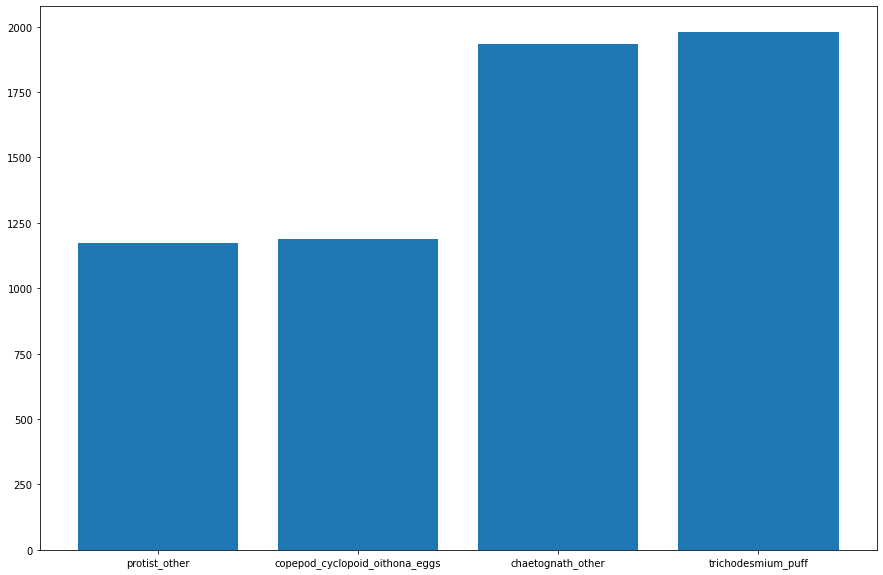

In [17]:
fileCount_df_sorted = fileCount_df.sort_values("Sample_Count")
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(fileCount_df_sorted["Class"], fileCount_df_sorted["Sample_Count"])
plt.show()

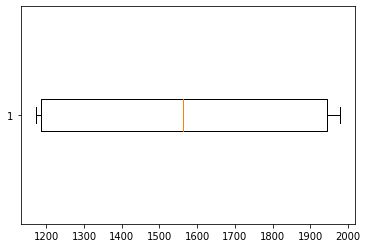

In [18]:
plt.boxplot(fileCount_df_sorted["Sample_Count"],vert=False)
plt.show()

In [20]:
# find images/classes that will need data augmentation
forDataAug_df = fileCount_df[fileCount_df["Sample_Count"] < fileCount_df["Sample_Count"].mean()]
#forDataAug_df = fileCount_df
forDataAug_df

,Path,Class,Sample_Count
0,../train/protist_other,protist_other,1172
2,../train/copepod_cyclopoid_oithona_eggs,copepod_cyclopoid_oithona_eggs,1189


In [21]:
fileCount_df["Sample_Count"].mean()

1568.5

**Generate The YAML File For YoloV5**

In [22]:
# Generate the required yaml file for Yolo
# yaml file describe the parameters of our dataset.

create_directory(yoloDirectory)

yamlFileName = "data.yaml"

file = open(yoloDirectory + yamlFileName, 'w')

file.write("train: " + str(yoloTrainImagesDirectory)  +
           "\nval: " + str(yoloValImagesDirectory) +  
           "\nnc: " + str(len(fileCount_df["Class"].tolist())) +
           "\nnames: " + str(fileCount_df["Class"].tolist()) 
          )

file.close()

**Dataset Augmenation**

In [23]:
# for clasess with less than median of the sample
for idx, row in forDataAug_df[forDataAug_df["Sample_Count"]<fileCount_df["Sample_Count"].mean()].iterrows():
    
    folder_name = row["Path"] + "/Rotate"
    
    for root, dirs, files in os.walk(folder_name):
        for file in files:
            os.remove(os.path.join(root, file))
    
    folder_name = row["Path"] + "/flip"
    
    for root, dirs, files in os.walk(folder_name):
        for file in files:
            os.remove(os.path.join(root, file))
    
    
    for image in os.listdir(row["Path"]):
        #src = row["Path"]+"/"+image
        #img = cv2.imread(src)
        
        if os.path.isfile(os.path.join(row["Path"], image)):
            #print("is File")
            flip_image(row["Path"], image, 0) # holrizontal flip
            flip_image(row["Path"], image, 1) # vertical flip
            #flip_image(row["Path"], image, -1) # both horizontal and vertical flip
        
            rotate_image(row["Path"], image, 90) # 90 degree rotation



# **Generate The Bounding Boxes For Yolov5 Format**
* First generate the bounding boxes using contour detection of OpenCV
* Convert the bounding boxes generated by OpenCV to Yolov5 format
* Generate label file for each image detailing Yolov5 bounding box infomration for each class in the image.

In [24]:
data = []
classID = 0
old_dir = ''
ClassID = 0
old_image = ''
    
for idx, row in fileCount_df.iterrows():
    dir = row["Class"]
    fullpath = os.path.join(dataDirectory,dir)
    #print(fullpath)
    
    classID = idx
    
    create_directory(yoloTrainImagesDirectory)
    
    create_directory(yoloTrainLabelsDirectory)
    
    for root, dirs, images in os.walk(fullpath):
        for image in images:
            #print(os.path.join(root,image))
            
            if old_image == image:
                print("duplicate image:", image)
            
            if old_image != image:
                #src = fullpath+"/"+image
                src = os.path.join(root,image)

                #print("source:",src)

                img = cv2.imread(src)

                # Pad Image to make it square
                old_image_height, old_image_width, channels = img.shape
                new_image_width = MaxImageSize
                new_image_height = MaxImageSize
                color = (255,255,255)            
                result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

                # compute center offset for padded image
                x_center = (new_image_width - old_image_width) // 2
                y_center = (new_image_height - old_image_height) // 2

                # copy img image into center of padded result image
                result[y_center:y_center+old_image_height,
                       x_center:x_center+old_image_width] = img

                #imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                imgGray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

                imgBlur = cv2.GaussianBlur(imgGray, (9, 9), 0)
                
                # Histogram adjustment for contrast correction
                imgHist = cv2.equalizeHist(imgBlur)

                # Set kernel for Halo removal
                kernel = np.ones((3, 3), np.uint8)
                # Halo removal
                imgOpening = cv2.morphologyEx(imgHist, cv2.MORPH_CLOSE, kernel)
                imgOpening = cv2.morphologyEx(imgOpening, cv2.MORPH_OPEN, kernel)
                
                # Canny Edge Detection
                imgCanny = cv2.Canny(imgOpening, 100, 50)  # higher value more smooth edges

                contours, hierarchy = cv2.findContours(imgCanny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                nContours = len(contours)

                if nContours == 0:
                    imgOpening = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
                    imgOpening = cv2.morphologyEx(imgOpening, cv2.MORPH_OPEN, kernel)
                    
                    imgCanny = cv2.Canny(imgOpening, 100, 50)
                    
                    contours, hierarchy = cv2.findContours(imgCanny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                    nContours = len(contours)

                imgContour = result.copy()

                imgArea = result.shape[0] * result.shape[1]

                maxArea = 0

                # Find area of detected contours and find the contour with max area
                for c in contours:
                    area = cv2.contourArea(c)
                    if area > maxArea:
                        maxArea = area

                # Use only the contour with max area for rest of processing
                for c in contours:
                    if cv2.contourArea(c) == maxArea:
                        cv2.drawContours(img, c, -1, (255, 0, 255), 10)

                        # Estimate the perimeter of closed contours
                        peri = cv2.arcLength(c, True)

                        # Approximate the number of corner points of each closed contour, of each object
                        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

                        # Create Object Corners
                        objCor = len(approx)

                        # Create bounding box around the object
                        x, y, w, h = cv2.boundingRect(approx)

                        # compute the center of the contour
                        M = cv2.moments(c)
                        cX = int(M["m10"] / M["m00"])
                        cY = int(M["m01"] / M["m00"])

                        cv2.rectangle(imgContour, (x, y), (x + w, y + h), (255, 0, 0), 2)

                        x_min = x
                        y_min = y
                        x_max = x + w
                        y_max = y + h

                        img_height, img_width, img_channel = result.shape

                        bbox = [x_min, y_min, w, h]

                        yolo_box = convert_to_yolo_format(img_width, img_height, bbox)

                        label_file = image.replace(".jpg", ".txt")

                        data.append([image, dir, classID, img_width, img_height, 
                                     bbox, label_file, yolo_box])

                        cv2.imwrite(yoloTrainImagesDirectory+image, result) 

                        # Generate label file for each image
                        file = open(yoloTrainLabelsDirectory + label_file, 'w')

                        # Each row is class x_center y_center width height format
                        # yolo_box[0] is x_center
                        # yolo_box[1] is y_center
                        # yolo_box[2] is Yolo bounding box width
                        # yolo_box[3] is Yolo bounding box height
                        file.write(str(classID) + " " + str(yolo_box[0]) + " " + 
                                   str(yolo_box[1]) + " " + str(yolo_box[2]) + " " +
                                   str(yolo_box[3]) + " " +
                                   '\n')
                        file.close()
                        
            old_image = image


In [25]:
header = ['image_id', 'class', 'class_id', 'width', 'height', 'bbox', 'label_file', 'yolo_box']

annotation_df = pd.DataFrame(data,columns=header)

In [26]:
annotation_df

,image_id,class,class_id,width,height,bbox,label_file,yolo_box
0,28913.jpg,protist_other,0,390,390,"[181, 178, 26, 31]",28913.txt,"[0.49743589743589745, 0.49615384615384617, 0.0..."
1,97990.jpg,protist_other,0,390,390,"[182, 182, 24, 25]",97990.txt,"[0.49743589743589745, 0.4987179487179487, 0.06..."
2,65127.jpg,protist_other,0,390,390,"[184, 180, 20, 27]",65127.txt,"[0.49743589743589745, 0.49615384615384617, 0.0..."
3,88633.jpg,protist_other,0,390,390,"[180, 181, 28, 27]",88633.txt,"[0.49743589743589745, 0.4987179487179487, 0.07..."
4,69344.jpg,protist_other,0,390,390,"[176, 178, 46, 33]",69344.txt,"[0.5102564102564102, 0.4987179487179487, 0.117..."
...,...,...,...,...,...,...,...,...
10991,29733.jpg,trichodesmium_puff,3,390,390,"[173, 170, 45, 52]",29733.txt,"[0.5012820512820513, 0.5025641025641026, 0.115..."
10992,90360.jpg,trichodesmium_puff,3,390,390,"[175, 178, 39, 33]",90360.txt,"[0.4987179487179487, 0.4987179487179487, 0.1, ..."
10993,21599.jpg,trichodesmium_puff,3,390,390,"[177, 176, 36, 36]",21599.txt,"[0.5, 0.49743589743589745, 0.09230769230769231..."
10994,17050.jpg,trichodesmium_puff,3,390,390,"[175, 178, 39, 33]",17050.txt,"[0.4987179487179487, 0.4987179487179487, 0.1, ..."


# **Split Dataset in Train And Validation**

In [27]:
train, val = train_test_split(annotation_df, test_size=0.2)

In [28]:
val

,image_id,class,class_id,width,height,bbox,label_file,yolo_box
7326,111608_90_rotated.jpg,copepod_cyclopoid_oithona_eggs,2,390,390,"[183, 183, 24, 25]",111608_90_rotated.txt,"[0.5, 0.5012820512820513, 0.06153846153846154,..."
1774,53086_90_rotated.jpg,protist_other,0,390,390,"[179, 184, 31, 24]",53086_90_rotated.txt,"[0.4987179487179487, 0.5025641025641026, 0.079..."
5357,149751.jpg,chaetognath_other,1,390,390,"[117, 133, 148, 135]",149751.txt,"[0.4897435897435897, 0.514102564102564, 0.3794..."
8986,41787_-1_fliped.jpg,copepod_cyclopoid_oithona_eggs,2,390,390,"[171, 171, 48, 46]",41787_-1_fliped.txt,"[0.5, 0.49743589743589745, 0.12307692307692308..."
2513,33449_-1_fliped.jpg,protist_other,0,390,390,"[178, 180, 38, 35]",33449_-1_fliped.txt,"[0.5051282051282051, 0.5064102564102564, 0.097..."
...,...,...,...,...,...,...,...,...
9352,54629.jpg,trichodesmium_puff,3,390,390,"[174, 173, 41, 41]",54629.txt,"[0.4987179487179487, 0.49615384615384617, 0.10..."
8753,88501_-1_fliped.jpg,copepod_cyclopoid_oithona_eggs,2,390,390,"[183, 182, 25, 24]",88501_-1_fliped.txt,"[0.5012820512820513, 0.49743589743589745, 0.06..."
8742,12421_-1_fliped.jpg,copepod_cyclopoid_oithona_eggs,2,390,390,"[181, 172, 26, 48]",12421_-1_fliped.txt,"[0.49743589743589745, 0.5025641025641026, 0.06..."
4170,79571.jpg,chaetognath_other,1,390,390,"[146, 180, 96, 25]",79571.txt,"[0.49743589743589745, 0.4935897435897436, 0.24..."


**Move Dataset To Respective Directories**

In [29]:
create_directory(yoloValImagesDirectory)
create_directory(yoloValLabelsDirectory)

for idx, row in val.iterrows(): 
    src_image = os.path.join(yoloTrainImagesDirectory,row["image_id"])
    src_label = os.path.join(yoloTrainLabelsDirectory,row["label_file"])
    #print(src_label)
    shutil.copy2(src_image, yoloValImagesDirectory)
    shutil.copy2(src_label, yoloValLabelsDirectory)
    
    os.remove(src_image)
    os.remove(src_label)

# **Train Yolov5 Model**
* Train the smallest available Yolov5 model, yolov5s.

In [31]:
# Uncomment below only if you have account on wandb.ai.
# It is used to store all results of the Yolo training/validation runs.
#%pip install -q wandb
#import wandb
#wandb.login()

     |████████████████████████████████| 1.8 MB 9.6 MB/s 
     |████████████████████████████████| 145 kB 91.0 MB/s 
     |████████████████████████████████| 181 kB 77.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [32]:
# Train using transfer learning by utilizing the existing weights of yolov5s
!python train.py --img 640 --batch 20 --epochs 300 --data ./yolo/data.yaml --weights yolov5s.pt --cache

wandb: Currently logged in as: abhishekkishore. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=./yolo/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=20, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-244-g47233e1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_p

**Test The Trained Yolov5 Model**

In [33]:
# Run model using the best weights found during training
# For each run of training within same session, /runs/train/exp folder is creation where n is the number of the experiment.
# For this case only one execution of training was done. Hence weights were available in /runs/train/exp/weights.
# The test image CountTestCollageDominant.jpg was manually uploaded to the colab.

!python detect.py --weights ./runs/train/exp/weights/best.pt --img 640 --conf 0.4 --source ../CountTestCollageDominant.jpg

detect: weights=['./runs/train/exp/weights/best.pt'], source=../CountTestCollageDominant.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-244-g47233e1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/CountTestCollageDominant.jpg: 256x640 2 chaetognath_others, 3 copepod_cyclopoid_oithona_eggss, 1 trichodesmium_puff, Done. (0.012s)
Speed: 0.4ms pre-process, 11.9ms inference, 1.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


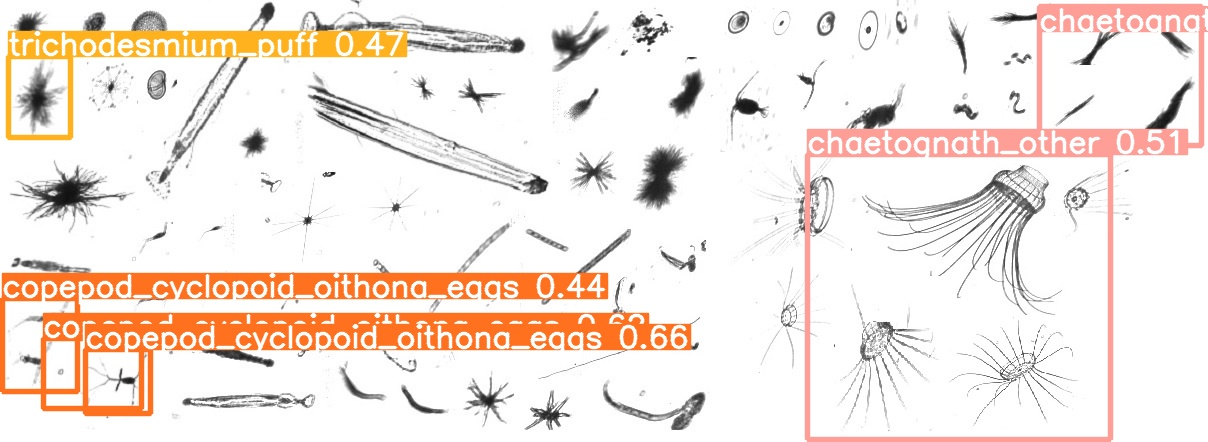

In [34]:
# Display the detection done on the given image
Image(filename='runs/detect/exp/CountTestCollageDominant.jpg',width=640)

# **Object Counting Implementation**

In [37]:
# Clone the zero shot object tracking
#!git clone --recurse-submodules https://github.com/roboflow-ai/zero-shot-object-tracking
!git clone -b fix-custom-weights https://github.com/ikitcheng/zero-shot-object-tracking.git
%cd ./zero-shot-object-tracking

Cloning into 'zero-shot-object-tracking'...
remote: Enumerating objects: 468, done.
remote: Total 468 (delta 0), reused 0 (delta 0), pack-reused 468
Receiving objects: 100% (468/468), 88.02 MiB | 19.04 MiB/s, done.
Resolving deltas: 100% (204/204), done.
/content/yolov5/zero-shot-object-tracking


In [38]:
# Close the OpenAI´s CLIP repository
!git clone https://github.com/openai/CLIP.git CLIP-repo
!cp -r ./CLIP-repo/clip ./clip

Cloning into 'CLIP-repo'...
remote: Enumerating objects: 222, done.
remote: Total 222 (delta 0), reused 0 (delta 0), pack-reused 222
Receiving objects: 100% (222/222), 8.92 MiB | 25.94 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [39]:
# Install requirements for zero shot and CLIP
!pip install --upgrade pip
!pip install -r requirements.txt
!pip install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 8.9 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.6/636.6 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Ignored the following versions that require a different python version: 1.4.0 Requires-Python >=3.8; 1.4.0rc0 Requires-Python >=3.8; 1.4.1 Requires-Python >=3.8; 1.4.2 Requires-Python >=3.8
ERROR: Could not find a version that satis

In [43]:
from google.colab import files
files.download('../runs/train/exp/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
# Run the object tracker on the same image used for testing Yolov5s.
# Use the weights found for Yolov5s

!python clip_object_tracker.py --weights ../runs/train/exp/weights/best.pt --source ../../CountTestCollageDominant.jpg --detection-engine yolov5 --info --view-img

#!python clip_object_tracker.py --source ./data/video/cars.mp4 --detection-engine yolov5 --weights custom_weights.pt

Namespace(agnostic_nms=False, api_key=None, augment=False, cfg='yolov4.cfg', classes=None, confidence=0.4, detection_engine='yolov5', device='', exist_ok=False, img_size=640, info=True, max_cosine_distance=0.4, name='exp', names='coco.names', nms_max_overlap=1.0, nn_budget=None, overlap=0.3, project='runs/detect', save_conf=False, save_txt=False, source='../CountTestCollage.mp4', thickness=3, update=False, url=None, view_img=True, weights=['../runs/train/exp/weights/best.pt'])
Fusing layers... 
Model Summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPS
Using torch 1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

video 1/1 (1/1) /content/yolov5/CountTestCollage.mp4: yolov5 inference

[Detections]
2 chaetognath_others, 2 copepod_cyclopoid_oithona_eggss, 1 trichodesmium_puffs, 
[Tracks] 5
Done. (0.011s)
: cannot connect to X server 
